### Model Info: loss: loss: 0.1195 - accuracy: 0.9512 - val_loss: 0.1865 - val_accuracy: 0.9396
Data: Grid

ImageDataGenerator( \
    rescale=1. / 255, \
    shear_range=0.2, \
    zoom_range=0.2, \
    horizontal_flip=True)
   
batch_size = 64 \
image_width = 224 \
image_height = 224 
    
optimizer='rmsprop
epochs=20

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime, os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [97]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"

--2022-04-08 18:15:20--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2022-04-08 18:15:20--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf33b67f19fbdc77bffe8ec135a.dl.dropboxusercontent.com/cd/0/inline/BjCDSr5vKJD8MHyLLyih12BWDtv25sN8p88XplfdxFz3HH3wgiNol-NZqAcaLu8f2M61hLixUrUpD5zQQPluhL8X_VeFsPIHtPzMTWcfP4a0RtkIMBBP-H2OgvWKlowgGJBk9pHAsJlzekqYd_M31EXLrWai0W3mG36yRE0ZqLjrdQ/file# [following]
--2022-04-08 18:15:20--  https://ucf33b67f19fbdc77bffe8ec135a.dl.dropboxusercontent.com/cd/0/inline/BjCDSr5vKJD8MHyLLyih12BWDtv25sN8p88XplfdxFz3HH3wgiNol-NZ

In [98]:
!tar -xvf 'grid_version.tar.1'

grid_version/
grid_version/validate/
grid_version/.DS_Store
grid_version/train/
grid_version/train/grid_no_smoke/
grid_version/train/.DS_Store
grid_version/train/grid_smoke/
grid_version/train/grid_smoke/1529002100_+01140_05_03.png
grid_version/train/grid_smoke/1529003240_+02280_05_03.png
grid_version/train/grid_smoke/1499547403_+01140_03_06.png
grid_version/train/grid_smoke/1499547763_+01500_05_07.png
grid_version/train/grid_smoke/1529002880_+01920_05_03.png
grid_version/train/grid_smoke/1528759446_+02040_06_08.png
grid_version/train/grid_smoke/1528759506_+02100_06_04.png
grid_version/train/grid_smoke/1498418253_+01860_05_08.png
grid_version/train/grid_smoke/1498418493_+02100_04_09.png
grid_version/train/grid_smoke/1529001560_+00600_06_04.png
grid_version/train/grid_smoke/1499547283_+01020_04_06.png
grid_version/train/grid_smoke/1528759686_+02280_05_06.png
grid_version/train/grid_smoke/1529022805_+02100_05_05.png
grid_version/train/grid_smoke/1530740065_+01020_04_07.png
grid_version/t

In [99]:
train_input_folder ='grid_version/train'
validate_input_folder = 'grid_version/validate'

In [23]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=bcfe0273835ff6e24a6972c039a7e3726d0fdf9026a37562c8b2d12d64eaf477
  Stored in directory: /home/jupyter/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [144]:
from imutils import paths
import os
import shutil
import random

def split_data(directory, validate_directory='validation', split=0.8): 
    directories = [os.path.join(directory, o) for o in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory,o))]
    print(directories)
    
    for directory in directories:
        image_paths = list(paths.list_images(directory))
    
        random.seed(32)
        random.shuffle(image_paths)
        image_paths

        # compute the training and testing split
        i = int(len(image_paths) * split)
        # print(i)
        print(len(image_paths) - i)
        train_paths = image_paths[:i]
        selected_for_validation_paths = image_paths[i:]

        new_train_dir = './sampled_train'
        new_val_dir = './sampled_validate'

        if os.path.isdir(new_train_dir) is False:
            os.makedirs(new_train_dir)
            os.makedirs(new_val_dir)

        for path in selected_for_validation_paths:
            category = os.path.basename(os.path.normpath(directory))
            # print(category)
            dest_path = os.path.join(new_val_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)

        for path in train_paths:
            category = os.path.basename(os.path.normpath(directory))
            # print(category)
            dest_path = os.path.join(new_train_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)  

In [145]:
split_data(directory='grid_version/train/', validate_directory='grid_version/validation')  

['grid_version/train/grid_no_smoke', 'grid_version/train/grid_smoke']
525
200


In [149]:
train_path = 'sampled_train'
test_path = 'sampled_validate'

In [147]:
#apply image augmentation
train_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
"""ImageDataGenerator(
    rescale=1./255)"""
    
test_image_generator = ImageDataGenerator(rescale=1./255)

In [150]:
# Variables for model
batch_size = 64
image_width = 224 
image_height = 224 
classes = ['grid_no_smoke','grid_smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

#create train data generator flowing from train_input_folder
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
#create validation data generator flowing from test_input_folder
test_generator = test_image_generator.flow_from_directory(
        test_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

Found 2895 images belonging to 2 classes.
Found 725 images belonging to 2 classes.


In [151]:
# img_input = layers.Input(shape=(image_width, image_height, 3))
input_shape = (image_width, image_height, 3)

In [152]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [153]:
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=test_generator,
      validation_steps=test_steps,
      epochs=epochs,
      callbacks=[tensorboard_callback])

Epoch 1/10
45/45 [==============================] - 95s 2s/step - loss: 0.9119 - accuracy: 0.7202 - val_loss: 0.5134 - val_accuracy: 0.7656
Epoch 2/10
45/45 [==============================] - 92s 2s/step - loss: 0.4446 - accuracy: 0.7838 - val_loss: 0.3782 - val_accuracy: 0.7599
Epoch 3/10
45/45 [==============================] - 91s 2s/step - loss: 0.4074 - accuracy: 0.8220 - val_loss: 0.2733 - val_accuracy: 0.8906
Epoch 4/10
45/45 [==============================] - 93s 2s/step - loss: 0.3096 - accuracy: 0.8753 - val_loss: 0.2274 - val_accuracy: 0.9290
Epoch 5/10
45/45 [==============================] - 92s 2s/step - loss: 0.2669 - accuracy: 0.8884 - val_loss: 0.3345 - val_accuracy: 0.8608
Epoch 6/10
45/45 [==============================] - 91s 2s/step - loss: 0.2536 - accuracy: 0.9018 - val_loss: 0.1736 - val_accuracy: 0.9474
Epoch 7/10
45/45 [==============================] - 91s 2s/step - loss: 0.2212 - accuracy: 0.9071 - val_loss: 0.1978 - val_accuracy: 0.9205
Epoch 8/10
45/45 [==

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

Text(0.5, 0, 'epoch')

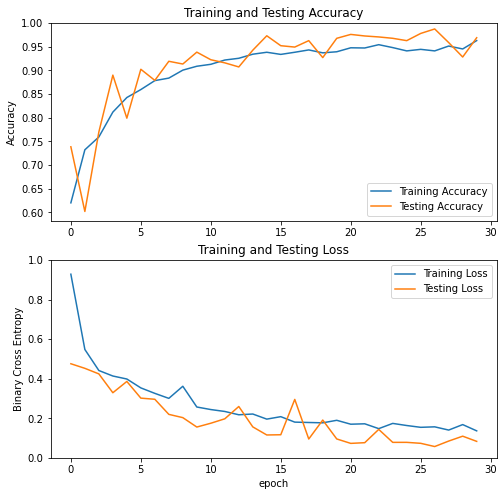

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')